In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [5]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [6]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['yes' 'go' 'no' 'right' 'left' 'down' 'stop' 'up']


In [8]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[500])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/yes/4a0e2c16_nohash_0.wav', shape=(), dtype=string)


In [9]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [10]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [11]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [10]:
  parts = tf.strings.split("/content/data/mini_speech_commands/down/004ae714_nohash_0.wav", os.path.sep)
  print(parts)

tf.Tensor(
[b'' b'content' b'data' b'mini_speech_commands' b'down'
 b'004ae714_nohash_0.wav'], shape=(6,), dtype=string)


In [12]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [13]:
audio_file = "/content/data/mini_speech_commands/down/004ae714_nohash_0.wav"
sequence, label = get_waveform_and_label(audio_file)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [15]:
samples = waveform_ds.take(1)
samples_as_list = list(samples.as_numpy_iterator())

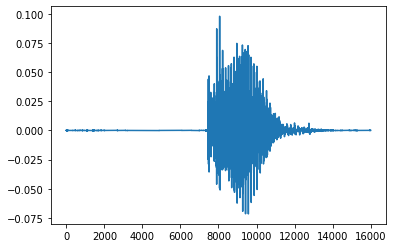

In [16]:
values, label = samples_as_list[0]
plt.plot(values)

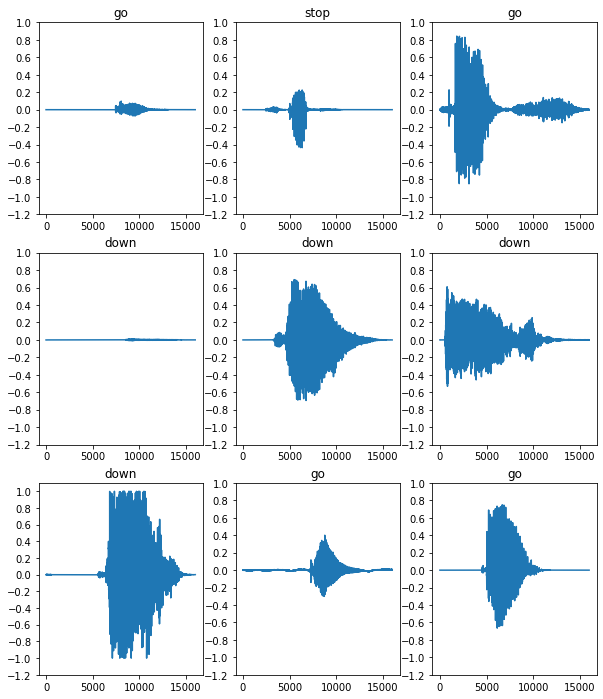

In [17]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)
plt.show()

# Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. The STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying tf.abs on the output of tf.signal.stft.

Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to this video on audio signal processing.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

In [71]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples  
#   n = waveform.shape[0]
#   num_elements_left = 16000 - n  
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
 # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
#   # The window length in samples.
#   # The number of samples to step: fft reqsolution.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=1024, frame_step=255
  )   
  spectrogram = tf.abs(spectrogram)
  return spectrogram

In [60]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')  
  spectrogram = get_spectrogram(waveform)

# audio_files = ["/content/data/mini_speech_commands/down/004ae714_nohash_0.wav",
#             "/content/data/mini_speech_commands/down/00b01445_nohash_1.wav"]
# def iter_function():
#     for f in audio_files:
#         yield get_waveform_and_label(f)

# for sample in iter_function():
#     print(sample)

subset_ds = waveform_ds.take(1)
list_of_samples = list(subset_ds.as_numpy_iterator())
amplitude_seq, label = list_of_samples[0]
print(label)

b'go'


In [58]:
print(amplitude_seq.shape)

(16000,)


In [61]:
from IPython import display
print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: b'go'
Waveform shape: (16000,)
Spectrogram shape: (59, 513)
Audio playback


In [62]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

(59, 513)


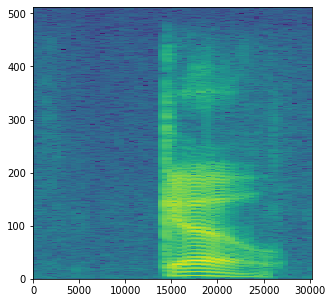

In [78]:
spec = get_spectrogram(amplitude_seq)
print(spec.shape)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plot_spectrogram(spec.numpy(), ax)


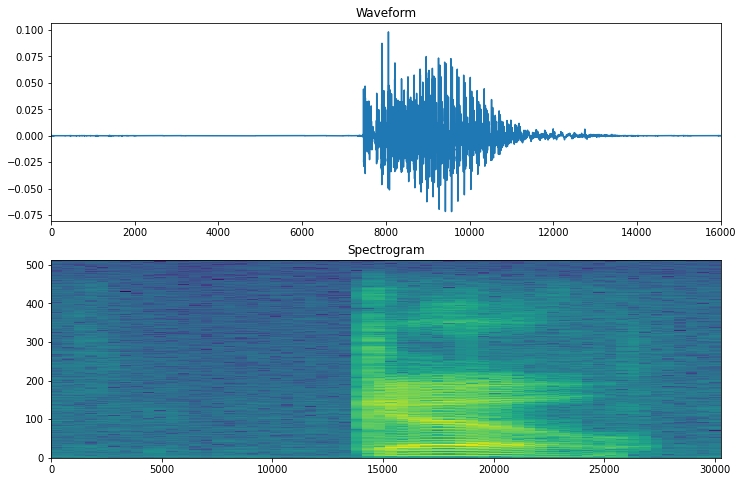

In [64]:

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [67]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [72]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

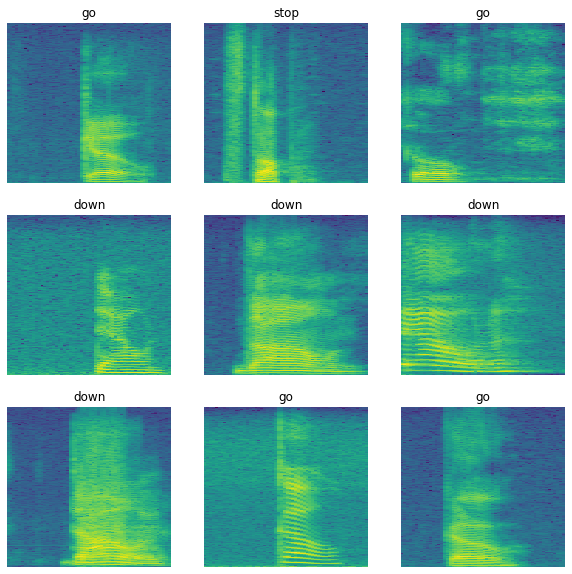

In [73]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [75]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [82]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [83]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [84]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [85]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation="softmax"),
])

model.summary()

Input shape: (59, 513, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (

In [86]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [87]:
EPOCHS = 50
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
100/100 [==============================] - 58s 574ms/step - loss: 1.8451 - accuracy: 0.3269 - val_loss: 1.5652 - val_accuracy: 0.4550
Epoch 2/50
100/100 [==============================] - 22s 215ms/step - loss: 1.4345 - accuracy: 0.4777 - val_loss: 1.2425 - val_accuracy: 0.5763
Epoch 3/50
100/100 [==============================] - 21s 215ms/step - loss: 1.1444 - accuracy: 0.5805 - val_loss: 1.0694 - val_accuracy: 0.6425
Epoch 4/50
100/100 [==============================] - 21s 213ms/step - loss: 0.9592 - accuracy: 0.6531 - val_loss: 0.9465 - val_accuracy: 0.6850
Epoch 5/50
100/100 [==============================] - 21s 214ms/step - loss: 0.8392 - accuracy: 0.6947 - val_loss: 0.8782 - val_accuracy: 0.7075
Epoch 6/50
100/100 [==============================] - 21s 214ms/step - loss: 0.7338 - accuracy: 0.7348 - val_loss: 0.8146 - val_accuracy: 0.7262
Epoch 7/50
100/100 [==============================] - 21s 213ms/step - loss: 0.6645 - accuracy: 0.7569 - val_loss: 0.7817 - val_ac

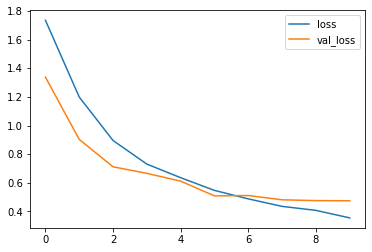

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpd7i1vxef/assets


INFO:tensorflow:Assets written to: /tmp/tmpd7i1vxef/assets


tf.Tensor(b'up', shape=(), dtype=string)


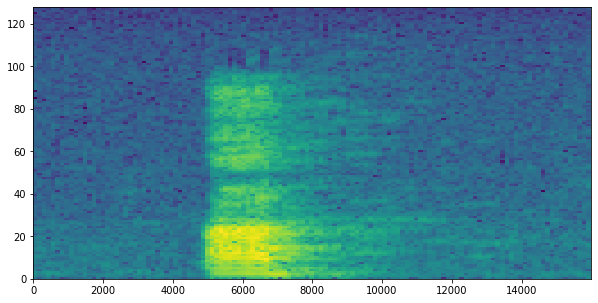

In [ ]:
waveform, label = get_waveform_and_label("/content/data/mini_speech_commands/up/0132a06d_nohash_2.wav")
print(label)
spectrogram = get_spectrogram(waveform)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
plt.show()